<font size=10em>Multi-label language classification</font>  

In this notebook we will learn how to solve the [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).  
The challenge is to determine if a comment taken from a Wikipedia edit discussion can be classified as one or more of the following:


*   toxic
*   severe_toxic
*   obscene
*   threat
*   insult
*   identity_hate

# preparation

## kaggle auth

In [36]:
# setting up kaggle authentication
# Just do one of the following

# -------------------------------------------------------------
# # 1. change permission    <<======== !!choose now!!
! chmod 600 ~/.kaggle/kaggle.json

# -------------------------------------------------------------
# 2. set environment variable  
# import os
# import json

# with open("../../token/kaggle.json", mode="r") as f:
#     json_data = json.load(f)
# os.environ["KAGGLE_USERNAME"] = json_data["username"]
# os.environ["KAGGLE_KEY"] = json_data["key"]

## Data Preparation

In [13]:
# # download data using kaggle API
# ! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
# # unzip the downloaded data
# ! unzip jigsaw-toxic-comment-classification-challenge.zip

In [14]:
# ds library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# model library
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
sub_sample = pd.read_csv('sample_submission.csv.zip')

# EDA

## overhead view

In [16]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [17]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [18]:
sub_sample

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## lavel columns

In [20]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
comments = train.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print(f"percent of {i}: {round(100*comments[i].mean(),2)}%")

percent of toxic: 9.58%
percent of severe_toxic: 1.0%
percent of obscene: 5.29%
percent of threat: 0.3%
percent of insult: 4.94%
percent of identity_hate: 0.88%


## comment_colmun

In [22]:
lens = train.comment_text.str.len()

print(f"""\
mean: {lens.mean():.2f}\n \
std: {lens.std():.2f}\n \
min: {lens.min()}\n \
max: {lens.max()}\n \
""")

mean: 394.07
 std: 590.72
 min: 6
 max: 5000
 


<AxesSubplot:xlabel='comment_text', ylabel='Count'>

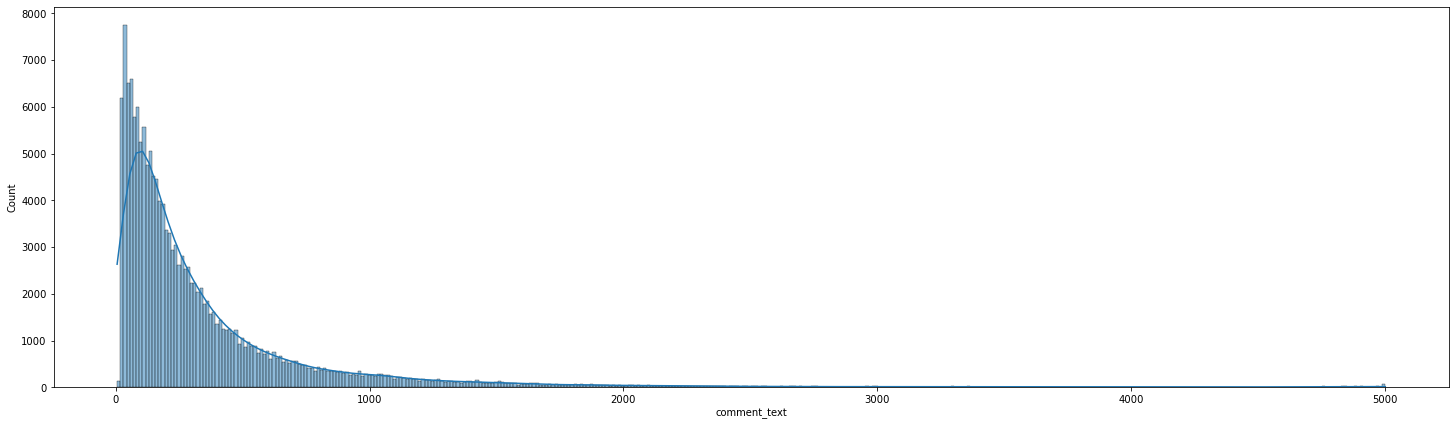

In [23]:
fig, ax = plt.subplots(figsize=(25, 7))
sns.histplot(data=lens, ax=ax, kde=True)

In [24]:
# create a list of all the labels to predict
label_cols = [cname for cname in train.columns 
              if train[cname].dtype == "int64"]
label_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [25]:
# create a [none] label so we can see how many comments have no labels
train["none"] = 1 - train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# building the model

bag of words  
Start by creating a bag of words representation as a document matrix of terms,  
using ngram as suggested on the NBSVM page.

In [26]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [27]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Using TF-IDF is expected to improve prediction accuracy compared to binaryization

In [28]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [29]:
# this creates a sparse matrix with only a small number of non-zero elements
trn_term_doc, test_term_doc

# ---------------------------------------------------
# if you want to see detail, active blow
# print(f"""
# {trn_term_doc} \n \
# {test_term_doc} \n \
# """)

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

In [30]:
# the basic naive bayes feature equation

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [31]:
x = trn_term_doc
test_x = test_term_doc

In [32]:
# fit a model for one dependent at a time

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [33]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

# submission

In [34]:
subid["id"] = sub_sample["id"]
sub = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
sub.to_csv('submission.csv', index=False)

In [35]:
# # submit using kaggle api
# ! kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "Message"